In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import data_handler_03 as dh
import my_simgraph_07 as sg
import assess_simgraph_02 as asg # change the sg package to my_simgraph_07 in assess_simgraph_02

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Assess the model's performance with random tests

In [5]:
def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

# data retrieval params
data_params = {'func': dh.datapoint_torch, 'lbl_func': dh.get_labels, 'features_dp': '../../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1}

# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv':0, 'Dvt':2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                'num_its':16, 'check_freq':1, 'print_checks':False, 'Theta0':None, \
                'force_all_its': True, 'threshold': 0.01}

# randomization parameters
rnd_params = {'train_sizes': [100, 150, 200, 250], 'val_sizes': [50], 'train_its': 3, 'val_its': 10, 'seed': None}
# rnd_params = {'train_sizes': [10, 20, 30], 'val_sizes': [10], 'train_its': 3, 'val_its': 3, 'seed': None}

# parameters to visualize the optimized M
f_sz = 474 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

# path to save the results
res_path = '../../../data/experiments/slowfast/slowfast_sg/temp/'

In [6]:
val_num_res, val_num_err = asg.assess_sg_model(data_params, sg_params, sg_opt_params, rnd_params, fig_params, res_path)

Done. Elapsed time: 1063.161 sec


In [21]:
res_path = '../../../data/experiments/comparison/2023_05_05-l1_l2/2023_05_05-l2norm/'
asg.plot_curves(rnd_params, sg_params, res_path)

# Compare training curves

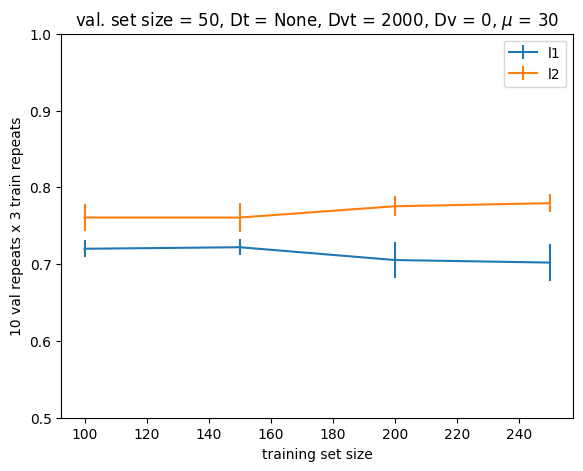

In [18]:
path = '../../../data/experiments/comparison/2023_05_05-l1_l2/'
# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']
assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

# read training curves of l1-norm
curves1 = {}
errors1 = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(path+'2023_05_05-l1norm/curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves1[quantity] = curves_i[j::8].reshape((1, -1))
            errors1[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves1[quantity] = np.concatenate((curves1[quantity], [curves_i[j::8]]), axis=0)
            errors1[quantity] = np.concatenate((errors1[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2
        
# read training curves of l2-norm
curves2 = {}
errors2 = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(path+'2023_05_05-l2norm/curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves2[quantity] = curves_i[j::8].reshape((1, -1))
            errors2[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves2[quantity] = np.concatenate((curves2[quantity], [curves_i[j::8]]), axis=0)
            errors2[quantity] = np.concatenate((errors2[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2

# plot training curves
plt.figure()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    quantity = 'val_acc'
    plt.errorbar(train_sizes, curves1[quantity][i], errors1[quantity][i])
    plt.errorbar(train_sizes, curves2[quantity][i], errors2[quantity][i])
    plt.ylim([0.5,1])
    plt.legend(['l1', 'l2'])
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title('val. set size = {}, Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}'.format(val_sizes[i], sg_params['Dt'], sg_params['Dvt'], sg_params['Dv'], sg_params['mu']))
plt.savefig(path+'compare_val_acc.png')
# plt.close()